<a href="https://colab.research.google.com/github/VishmiVithanage/sdgp-project/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependancies and setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [122]:
import tensorflow as tf
import os

In [123]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [124]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Remove Dodgy Images

In [125]:
import cv2
import imghdr

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
dataset_path = '/content/drive/My Drive/dataset/Database'

In [128]:
os.listdir(dataset_path)

['Karanda',
 'Lemon',
 'Mint',
 'Oleander',
 'Pomegranate',
 'Mustard',
 'Coriander',
 'Balloon vine']

In [129]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [130]:
for image_class in os.listdir(dataset_path):
  print(image_class)

Karanda
Lemon
Mint
Oleander
Pomegranate
Mustard
Coriander
Balloon vine


In [131]:
for image_class in os.listdir(dataset_path): 
    for image in os.listdir(os.path.join(dataset_path, image_class)):
        image_path = os.path.join(dataset_path, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

Load Data

In [132]:
import numpy as np
from matplotlib import pyplot as plt

In [133]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/My Drive/dataset/Database')

Found 751 files belonging to 8 classes.


In [134]:
data_iterator = data.as_numpy_iterator()

In [135]:
batch = data_iterator.next()

In [136]:
len(batch)

2

In [137]:
batch[0].shape

(32, 256, 256, 3)

In [138]:
batch[1]

array([2, 1, 6, 2, 3, 7, 7, 7, 3, 1, 4, 5, 7, 2, 1, 0, 6, 5, 0, 0, 7, 4,
       4, 5, 2, 5, 0, 2, 6, 0, 3, 5], dtype=int32)

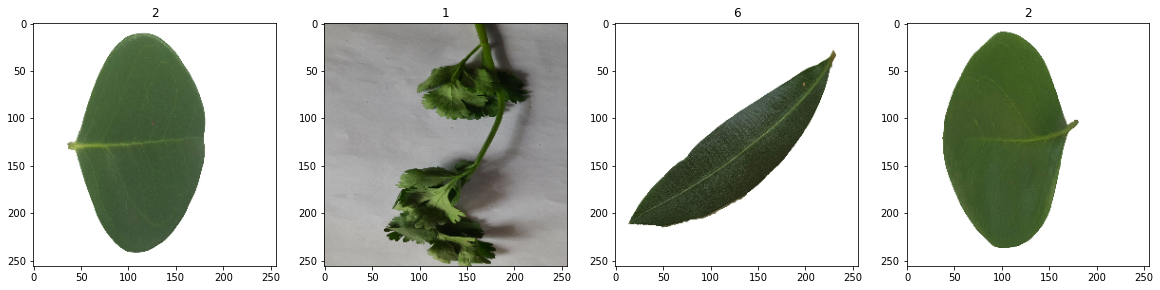

In [140]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [141]:
batch[0].max()

255.0

Data Preprocessing

Scale Data/ Normalize

In [142]:
data = data.map(lambda x,y: (x/255, y))

In [143]:
data.as_numpy_iterator().next()[0].max()

1.0

Split Data

In [144]:
len(data)

24

In [145]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [146]:
train_size+val_size+test_size

24

In [147]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [148]:
len(train)

16

Build Model

In [149]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [151]:
model = Sequential()

In [152]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [153]:
model.compile(optimizer = 'adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

Train

In [155]:
logdir='logs'

In [156]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [157]:
hist = model.fit(train, epochs=8, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
16/16 [==============================] - 53s 3s/step - loss: 1.8017 - accuracy: 0.3301 - val_loss: 0.9252 - val_accuracy: 0.7375
Epoch 2/8
16/16 [==============================] - 51s 3s/step - loss: 0.6562 - accuracy: 0.7812 - val_loss: 0.5878 - val_accuracy: 0.7625
Epoch 3/8
16/16 [==============================] - 51s 3s/step - loss: 0.4531 - accuracy: 0.8457 - val_loss: 0.2654 - val_accuracy: 0.8875
Epoch 4/8
16/16 [==============================] - 52s 3s/step - loss: 0.2491 - accuracy: 0.9141 - val_loss: 0.2752 - val_accuracy: 0.9062
Epoch 5/8
16/16 [==============================] - 49s 3s/step - loss: 0.1790 - accuracy: 0.9395 - val_loss: 0.1597 - val_accuracy: 0.9625
Epoch 6/8
16/16 [==============================] - 50s 3s/step - loss: 0.1302 - accuracy: 0.9570 - val_loss: 0.1502 - val_accuracy: 0.9563
Epoch 7/8
16/16 [==============================] - 50s 3s/step - loss: 0.0842 - accuracy: 0.9648 - val_loss: 0.1670 - val_accuracy: 0.9500
Epoch 8/8
16/16 [==========

Plot Performance

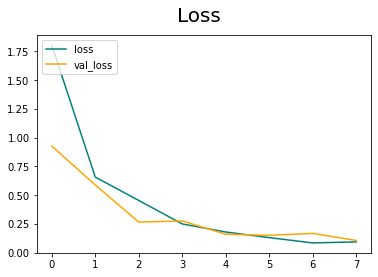

In [158]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

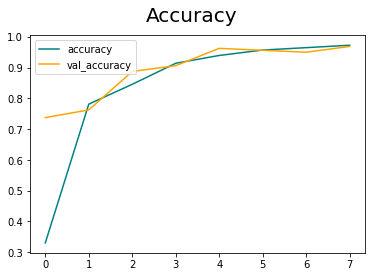

In [159]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate

In [160]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.utils import to_categorical

In [161]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [162]:
for batch in test.as_numpy_iterator():
  x, y = batch
  y = to_categorical(y, num_classes=8)
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 120ms/step


In [163]:
print (f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9871794581413269, Recall:0.9746835231781006, Accuracy:0.9952531456947327


Test

In [164]:
import cv2

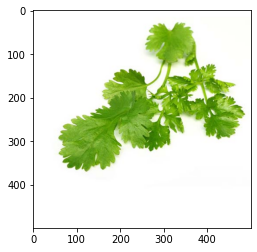

In [171]:
img = cv2.imread('/content/drive/My Drive/dataset/corianderTest.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
plt.imshow(img.astype('uint8')) # Convert data type to uint8
plt.show()

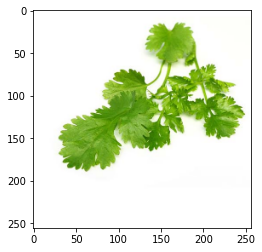

In [172]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [173]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 22ms/step


In [174]:
yhat

array([[2.6113393e-02, 9.7388315e-01, 2.0091564e-14, 1.2139279e-08,
        1.1719110e-13, 2.8685226e-06, 6.3295852e-07, 2.5406224e-09]],
      dtype=float32)